# 1. Install Required Libraries

Installing essential Python libraries needed for data preprocessing, model training, and evaluation.

In [1]:
!pip install pandas numpy scikit-learn matplotlib seaborn tensorflow transformers nltk symspellpy contractions


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.1/144.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.7 MB/s eta 0:00:00


# 2. Import Necessary Libraries

Importing all required Python libraries for text processing, machine learning, and deep learning

In [2]:
import pandas as pd
import numpy as np
import re
import string
import contractions
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from transformers import BertTokenizer, TFBertForSequenceClassification, TFRobertaForSequenceClassification, TFXLNetForSequenceClassification
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dropout, Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
from symspellpy import SymSpell, Verbosity
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import nltk
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# 3. Load and Prepare Dataset

Loading the Fake News and True News datasets and assigning labels.

In [3]:
# Load datasets
data_fake = pd.read_csv('Fake.csv')
data_true = pd.read_csv('True.csv')

# Assign labels (0 = Fake, 1 = True)
data_fake['class'] = 0
data_true['class'] = 1

# Keep only required columns
data_fake = data_fake[['text', 'class']]
data_true = data_true[['text', 'class']]

# Combine both datasets
data = pd.concat([data_fake, data_true], axis=0).reset_index(drop=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


# 4. Text Preprocessing

Cleaning the text data by removing noise, expanding contractions, and correcting spelling errors.

In [4]:
# Initialize SymSpell
sym_spell = SymSpell(max_dictionary_edit_distance=2)
sym_spell.load_dictionary("frequency_dictionary_en_82_765.txt", term_index=0, count_index=1)

# Initialize other preprocessing tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    # Fast spell correction with SymSpell
    corrected_words = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected_words)

# Parallel processing for faster execution
data['text'] = Parallel(n_jobs=-1)(delayed(clean_text)(text) for text in data['text'])


2025-03-22 17:10:06,467: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en_82_765.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en_82_765.txt.


# 5. Train-Test Split

Splitting the dataset into training, validation, and test sets. Train (70%)
Validation (15%)
Test (15%)

In [5]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

x_train, y_train = train_data['text'], train_data['class']
x_valid, y_valid = valid_data['text'], valid_data['class']
x_test, y_test = test_data['text'], test_data['class']


# 6. TF-IDF Vectorization

Converting text data into numerical format using TF-IDF Vectorizer.

In [6]:
vectorizer = TfidfVectorizer(max_features=5000)
xv_train = vectorizer.fit_transform(x_train)
xv_valid = vectorizer.transform(x_valid)
xv_test = vectorizer.transform(x_test)

# 7. Train Machine Learning Models

Training multiple ML models and evaluating their performance.

In [7]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(xv_train, y_train)
    preds = model.predict(xv_valid)
    acc = accuracy_score(y_valid, preds)
    results[name] = acc


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:16:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 8. Train LSTM Model

Building and training an LSTM-based deep learning model.

In [8]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(x_train)
x_train_seq = pad_sequences(tokenizer.texts_to_sequences(x_train), maxlen=100)
x_valid_seq = pad_sequences(tokenizer.texts_to_sequences(x_valid), maxlen=100)
x_test_seq = pad_sequences(tokenizer.texts_to_sequences(x_test), maxlen=100)

lstm_model = Sequential([
    Embedding(5000, 128, input_length=100),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(128),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(x_train_seq, y_train, epochs=200, validation_data=(x_valid_seq, y_valid))


Epoch 1/200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


983/983 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9253 - loss: 0.1812 - val_accuracy: 0.9837 - val_loss: 0.0483
Epoch 2/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9880 - loss: 0.0397 - val_accuracy: 0.9869 - val_loss: 0.0474
Epoch 3/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9917 - loss: 0.0258 - val_accuracy: 0.9852 - val_loss: 0.0496
Epoch 4/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.9963 - loss: 0.0128 - val_accuracy: 0.9880 - val_loss: 0.0472
Epoch 5/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 0.9893 - val_loss: 0.0429
Epoch 6/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9958 - loss: 0.0141 - val_accuracy: 0.9886 - val_loss: 0.0475
Epoch 7/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.9982 - loss: 0.0061 - val_accuracy: 0.9871 - val_loss: 0.0520
Epoch 8/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.9987 - loss: 0.0040 - val_

# 9. Train CNN + LSTM Hybrid Model

Combining CNN and LSTM layers for better performance.

In [9]:
cnn_lstm_model = Sequential([
    Embedding(5000, 128, input_length=100),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.fit(x_train_seq, y_train, epochs=200, validation_data=(x_valid_seq, y_valid))


Epoch 1/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9157 - loss: 0.1841 - val_accuracy: 0.9869 - val_loss: 0.0401
Epoch 2/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9930 - loss: 0.0229 - val_accuracy: 0.9887 - val_loss: 0.0388
Epoch 3/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9971 - loss: 0.0088 - val_accuracy: 0.9869 - val_loss: 0.0412
Epoch 4/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - accuracy: 0.9989 - loss: 0.0040 - val_accuracy: 0.9843 - val_loss: 0.0570
Epoch 5/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9981 - loss: 0.0051 - val_accuracy: 0.9898 - val_loss: 0.0442
Epoch 6/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9901 - val_loss: 0.0476
Epoch 7/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9995 - loss: 0.0024 - val_accuracy: 0.9886 - val_loss: 0.0652
Epoch 8/200
983/983 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.9992 - loss: 0.0027 - val

# 10. Confusion Matrix

Visualizing model performance using confusion matrices.

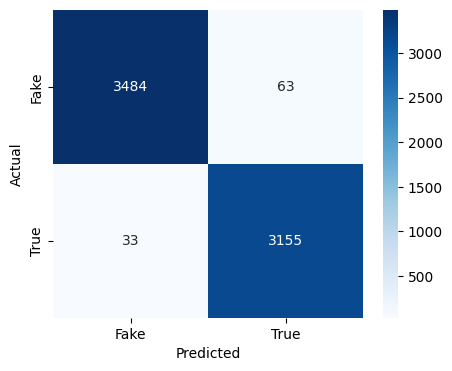

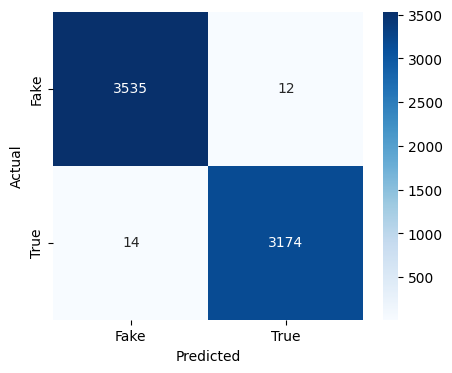

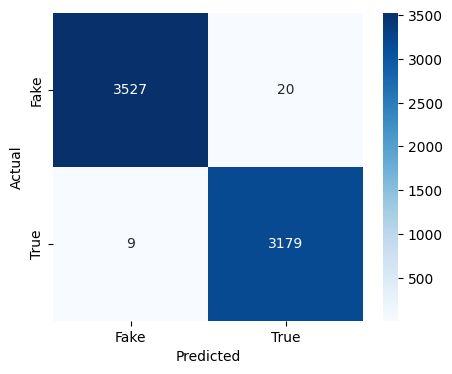

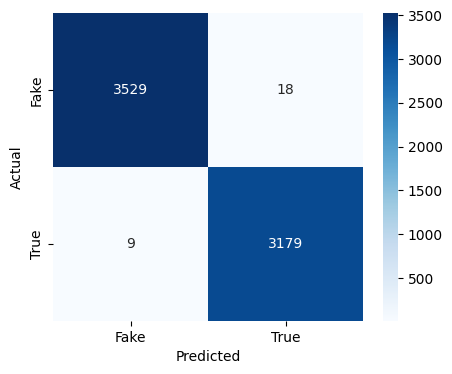

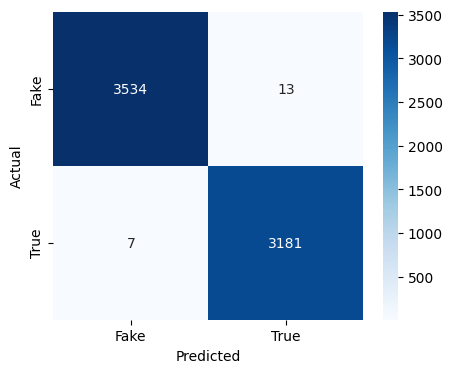

211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


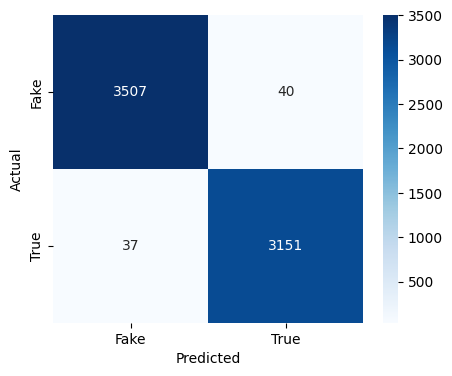

211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


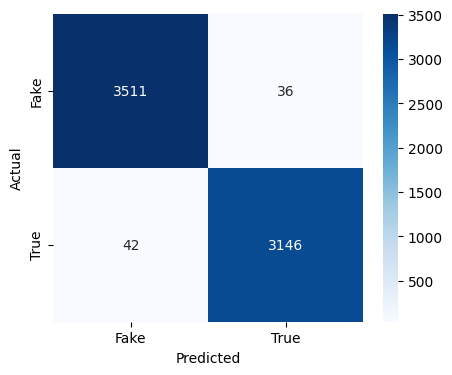

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Function to plot and save confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))  # Moved inside the loop
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    #plt.title(f"Confusion Matrix - {model_name}")
    plt.savefig(f'{model_name}_confusion_matrix.png')  # Save the plot
    plt.show()

# Plot and save for each ML model
for name, model in models.items():
    preds = model.predict(xv_test)
    plot_confusion_matrix(y_test, preds, name)

# LSTM Confusion Matrix
lstm_preds = (lstm_model.predict(x_test_seq) > 0.5).astype(int)
plot_confusion_matrix(y_test, lstm_preds, "LSTM")

# CNN + LSTM Confusion Matrix
cnn_lstm_preds = (cnn_lstm_model.predict(x_test_seq) > 0.5).astype(int)
plot_confusion_matrix(y_test, cnn_lstm_preds, "CNN + LSTM")

# 11. Model Accuracy Comparison

Comparing model performances using a bar graph.

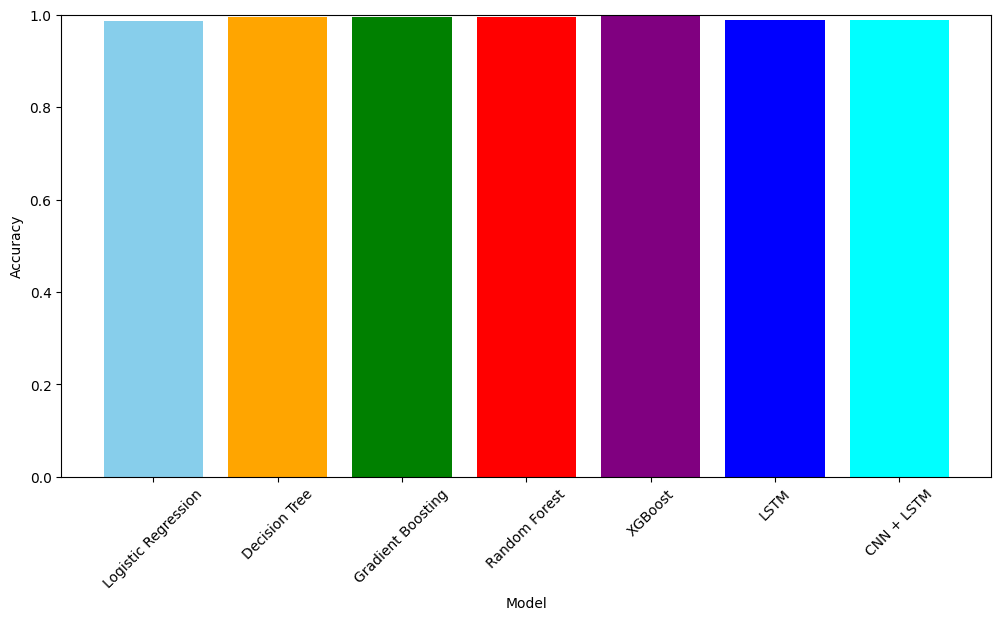

In [11]:
# Store accuracies
model_accuracies = {
    'Logistic Regression': accuracy_score(y_test, models['Logistic Regression'].predict(xv_test)),
    'Decision Tree': accuracy_score(y_test, models['Decision Tree'].predict(xv_test)),
    'Gradient Boosting': accuracy_score(y_test, models['Gradient Boosting'].predict(xv_test)),
    'Random Forest': accuracy_score(y_test, models['Random Forest'].predict(xv_test)),
    'XGBoost': accuracy_score(y_test, models['XGBoost'].predict(xv_test)),
    'LSTM': accuracy_score(y_test, lstm_preds),
    'CNN + LSTM': accuracy_score(y_test, cnn_lstm_preds),
}

# Plot bar graph
plt.figure(figsize=(12, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color=['skyblue', 'orange', 'green', 'red', 'purple', 'blue', 'cyan'])
#plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)  # Accuracy ranges between 0 and 1
plt.xticks(rotation=45)
plt.savefig('model_accuracy_comparison.png')  # Save the plot
plt.show()

# 12. AUROC Graphs

Plotting the Area Under the Receiver Operating Characteristic (AUROC) curve to evaluate model performance.

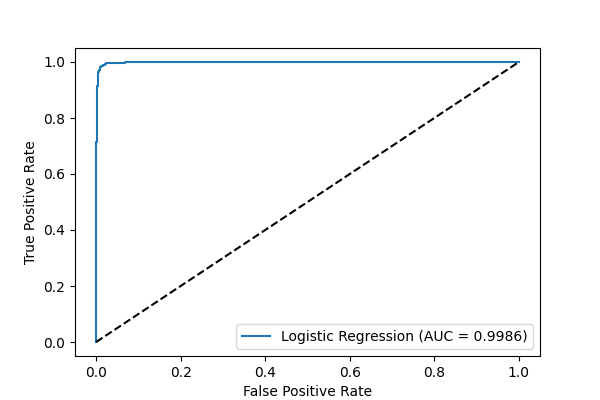

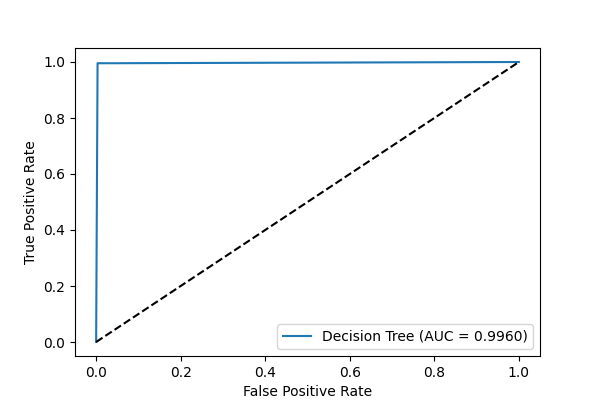

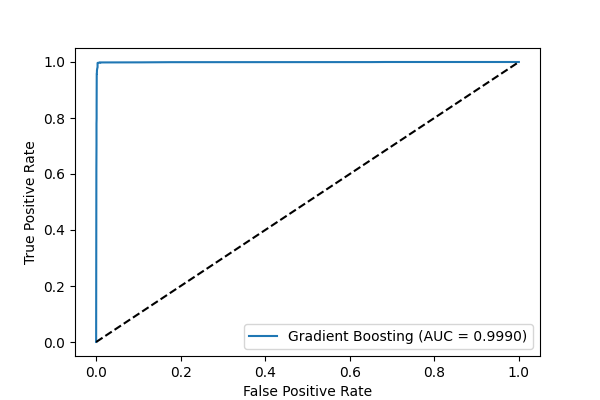

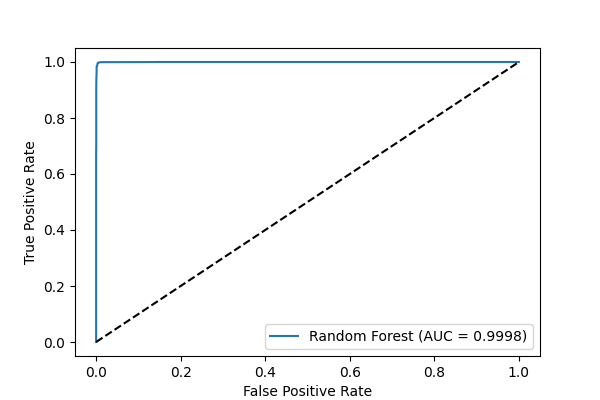

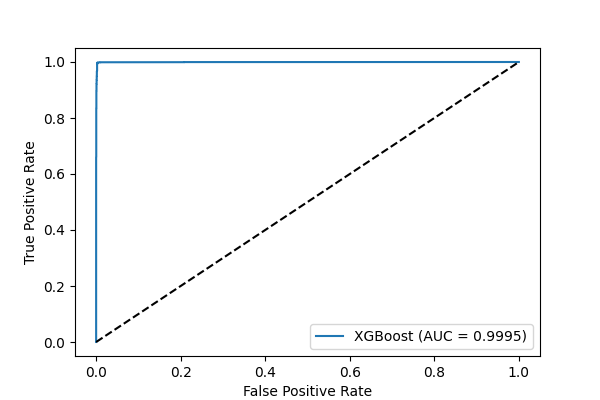

211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


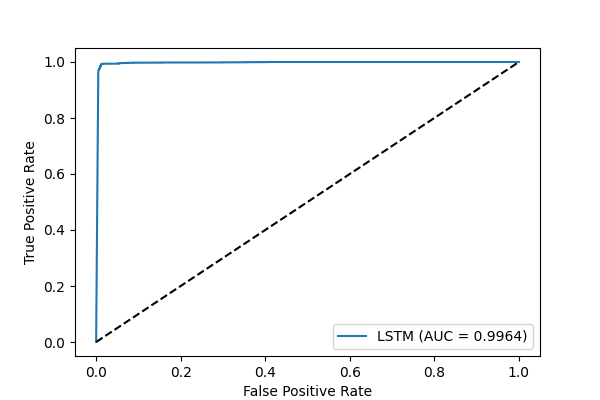

211/211 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


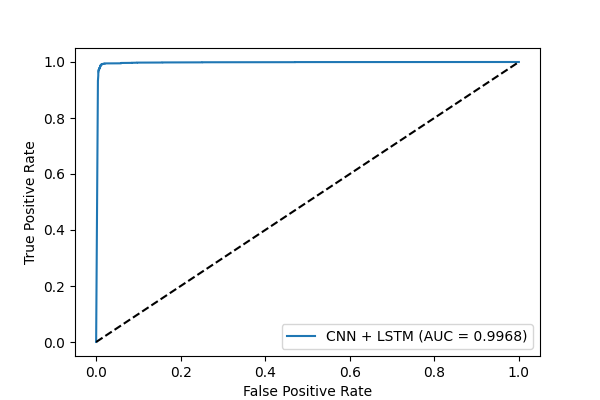

AUROC graphs saved and displayed as separate images.


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from IPython.display import Image, display

# Function to plot, save, and display ROC curve for a model
def plot_save_display_roc_curve(y_true, y_pred_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
   # plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

    # Save the plot
    plt.savefig(f'{model_name}_ROC_Curve.png')

    # Display the plot
    display(Image(filename=f'{model_name}_ROC_Curve.png'))

    plt.close()  # Close the figure to avoid overlapping plots

# Plot, save, and display for each ML model
for name, model in models.items():
    y_pred_prob = model.predict_proba(xv_test)[:, 1]
    plot_save_display_roc_curve(y_test, y_pred_prob, name)

# LSTM
y_pred_prob_lstm = lstm_model.predict(x_test_seq)
plot_save_display_roc_curve(y_test, y_pred_prob_lstm, "LSTM")

# CNN + LSTM
y_pred_prob_cnn_lstm = cnn_lstm_model.predict(x_test_seq)
plot_save_display_roc_curve(y_test, y_pred_prob_cnn_lstm, "CNN + LSTM")

print("AUROC graphs saved and displayed as separate images.")

# 13. Evaluation Metrics

Calculating and displaying precision, recall, F1-score, and accuracy for each model.

In [13]:
from sklearn.metrics import confusion_matrix, roc_auc_score, precision_score, f1_score, recall_score

# Assuming you have predictions for all models stored in variables like 'lr_preds', 'dt_preds', etc.
# Replace these with your actual prediction variables

# Function to calculate and print metrics
def evaluate_model(y_true, y_pred, model_name):
    print(f"Metrics for {model_name}:")

     # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {accuracy}")
    print("-" * 20)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # AUROC
    auroc = roc_auc_score(y_true, y_pred)
    print(f"AUROC: {auroc}")

    # Precision
    precision = precision_score(y_true, y_pred)
    print(f"Precision: {precision}")

    # F1 Score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1}")

    # Sensitivity (Recall)
    sensitivity = recall_score(y_true, y_pred)
    print(f"Sensitivity: {sensitivity}")

    # Specificity
    specificity = cm[0, 0] / (cm[0, 0] + cm[0, 1])  # TN / (TN + FP)
    print(f"Specificity: {specificity}")
    print("-" * 20)

# Evaluate each model
for model_name, model in models.items():  # Assuming 'models' is your dictionary of models
    y_pred = model.predict(xv_test)  # Replace with appropriate prediction data
    evaluate_model(y_test, y_pred, model_name)

# Evaluate LSTM model
lstm_preds = (lstm_model.predict(x_test_seq) > 0.5).astype(int)  # Assuming 'lstm_model' is your LSTM model
evaluate_model(y_test, lstm_preds, "LSTM")

# Evaluate CNN + LSTM model
cnn_lstm_preds = (cnn_lstm_model.predict(x_test_seq) > 0.5).astype(int)  # Assuming 'cnn_lstm_model' is your CNN + LSTM model
evaluate_model(y_test, cnn_lstm_preds, "CNN + LSTM")


Metrics for Logistic Regression:
Accuracy: 0.9857461024498887
--------------------
Confusion Matrix:
[[3484   63]
 [  33 3155]]
AUROC: 0.9859435969888491
Precision: 0.9804226227470478
F1 Score: 0.9850140493287542
Sensitivity: 0.9896486825595985
Specificity: 0.9822385114180998
--------------------
Metrics for Decision Tree:
Accuracy: 0.9961395694135116
--------------------
Confusion Matrix:
[[3535   12]
 [  14 3174]]
AUROC: 0.9961126956563572
Precision: 0.9962335216572504
F1 Score: 0.9959209287731409
Sensitivity: 0.9956085319949812
Specificity: 0.9966168593177333
--------------------
Metrics for Gradient Boosting:
Accuracy: 0.9956941351150705
--------------------
Confusion Matrix:
[[3527   20]
 [   9 3179]]
AUROC: 0.9957691728107837
Precision: 0.9937480462644577
F1 Score: 0.995459527164553
Sensitivity: 0.9971769134253451
Specificity: 0.9943614321962222
--------------------
Metrics for Random Forest:
Accuracy: 0.9959910913140312
--------------------
Confusion Matrix:
[[3529   18]
 [   9 

# 14. Model Saves

Saving the trained models for future use.

In [14]:
import joblib
import pickle

# Save TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save Machine Learning models using joblib
for name, model in models.items():
    joblib.dump(model, f'{name.replace(" ", "_")}.pkl')

# Save Keras models using TensorFlow's save method
lstm_model.save('lstm_model.h5')
cnn_lstm_model.save('cnn_lstm_model.h5')

# Save Tokenizer for Deep Learning models
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# 15.Model Tesing

This section will prompt the user to enter news text, preprocess it, and test it with all trained models.

In [28]:
import joblib
import re
import string
import contractions
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from symspellpy import SymSpell, Verbosity
import pickle

# Load pre-trained ML models
xgb_model = joblib.load('XGBoost.pkl')
rf_model = joblib.load('Random_Forest.pkl')
lr_model = joblib.load('Logistic_Regression.pkl')
dt_model = joblib.load('Decision_Tree.pkl')
gb_model = joblib.load('Gradient_Boosting.pkl')

# Load deep learning models
lstm_model = tf.keras.models.load_model('lstm_model.h5')
cnn_lstm_model = tf.keras.models.load_model('cnn_lstm_model.h5')

# Load TF-IDF vectorizer (for ML models)
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# Load Tokenizer for LSTM & CNN models
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load SymSpell for fast spell correction
sym_spell = SymSpell(max_dictionary_edit_distance=2)
sym_spell.load_dictionary('frequency_dictionary_en.txt', term_index=0, count_index=1)

# Define Text Cleaning Function
def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    corrected_words = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected_words)

# Function for LSTM & CNN Model Input Processing
def preprocess_for_lstm_cnn(text):
    text_seq = tokenizer.texts_to_sequences([text])
    return pad_sequences(text_seq, maxlen=200)

# Get User Input
user_input = input("Enter news text for classification: ")
processed_input = clean_text(user_input)

# TF-IDF Vectorization for Traditional ML Models
input_vector = vectorizer.transform([processed_input])

# Predictions from ML Models
ml_predictions = {
    "XGBoost": xgb_model.predict(input_vector)[0],
    "Random Forest": rf_model.predict(input_vector)[0],
    "Logistic Regression": lr_model.predict(input_vector)[0],
    "Decision Tree": dt_model.predict(input_vector)[0],
    "Gradient Boosting": gb_model.predict(input_vector)[0],
}

# Predictions from LSTM & CNN
lstm_pred = lstm_model.predict(preprocess_for_lstm_cnn(processed_input))[0][0]
# cnn_pred = cnn_model.predict(preprocess_for_lstm_cnn(processed_input))[0][0]
cnn_lstm_pred = cnn_lstm_model.predict(preprocess_for_lstm_cnn(processed_input))[0][0]

# Display Predictions
print("\nModel Predictions:")
for model, pred in ml_predictions.items():
    print(f"{model}: {'REAL' if pred == 1 else 'FAKE'}")

print(f"LSTM: {'REAL' if lstm_pred > 0.5 else 'FAKE'}")
# print(f"CNN: {'REAL' if cnn_pred > 0.5 else 'FAKE'}")
print(f"CNN + LSTM: {'REAL' if cnn_lstm_pred > 0.5 else 'FAKE'}")


2025-03-22 18:56:53,269: E symspellpy.symspellpy] Dictionary file not found at frequency_dictionary_en.txt.
ERROR:symspellpy.symspellpy:Dictionary file not found at frequency_dictionary_en.txt.


Enter news text for classification: The following statementsÂ were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own.Â Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump : - Together, we are MAKING AMERICA GREAT AGAIN! bit.ly/2lnpKaq [1814 EST] - In the East, it could be the COLDEST New Yearâ€™s Eve on record. Perhaps we could use a little bit of that good old Global Warming that our Country, but not other countries, was going to pay TRILLIONS OF DOLLARS to protect against. Bundle up! [1901 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

Model Predictions:
XGBoost: REAL
Random Forest: REAL
Logistic Regression: REAL
Decision Tree: REAL
Gradient Boosting: REAL
LSTM: REAL
CNN + LSTM: REAL


In [27]:
import joblib

# 1. Load the trained XGBoost model
xgb_model = joblib.load('XGBoost.pkl')

# 2. Load the TF-IDF vectorizer
vectorizer = joblib.load('tfidf_vectorizer.pkl')

# 3. Preprocess the input text
def clean_text(text):  # You need to apply the actual cleaning logic here
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])

    # Fast spell correction with SymSpell
    corrected_words = []
    for word in text.split():
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=2)
        corrected_words.append(suggestions[0].term if suggestions else word)
    return ' '.join(corrected_words)


def preprocess_text(text):
    # Apply the same preprocessing steps used during training
    # This might involve cleaning, lemmatization, etc.
    cleaned_text = clean_text(text)  # Call the cleaning function and store the result
    return cleaned_text

# 4. Get user input
user_input = input("Enter news text for classification: ")

# 5. Preprocess the user input
processed_input = preprocess_text(user_input)

# 6. Vectorize the preprocessed input
input_vector = vectorizer.transform([processed_input])

# 7. Make prediction
prediction = xgb_model.predict(input_vector)[0]

# 8. Interpret the prediction
if prediction == 0:
    print("XGBoost Prediction: FAKE")
else:
    print("XGBoost Prediction: REAL")

Enter news text for classification: Patrick Henningsen  21st Century WireRemember when the Obama Administration told the world how it hoped to identify 5,000 reliable non-jihadist  moderate  rebels hanging out in Turkey and Jordan, who might want to fight for Washington in Syria? After all the drama over its infamous  train and equip  program to create their own Arab army in Syria, they want to give it another try.This week, Pentagon officials announced their new plan to train up to 7,000 more  moderate  fighters, but this time the project would take place inside Syria (and to hell with international law).We re told that this was requested by Ankara, and with all NATO allies singing the same hymn   claiming that this new effort will help in securing Turkey s porous border with Syria, or so the story goes. Washington s political cover for this is fashioned from the popular post-Paris theme: to protect civilized Europe from invading hordes and the terrorists who hide among them, as state